In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import os
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from torchmetrics import Accuracy
from sklearn.metrics import f1_score
import torch.nn.init as init

import os
# 更改工作目录
os.chdir('/home/ubuntu/zlb/MEIJU/train_model')

import config as cf
# 定义的模型
from transformer_model import MultimodalDataset,MultimodalEmotionRecognition

In [2]:
# 获取各个特征的维数

TEXT_DIM,AUDIO_DIM,VIDEO_DIM = cf.get_feature_dim()

# 分别代表 text，audio，video向量的维度
print(cf.get_feature_dim())

(768, 512, 1024)


In [3]:
# 需要搜寻的最优超参数组合

param_grid = {
    'learning_rate': [0.0001],
    'batch_size': [32,16],
    'text_head': [16], 
    'text_layers':[2],
    'audio_head': [16], 
    'audio_layers':[2],
    'video_head': [16], 
    'video_layers':[2],
    'epochs': [5] 
    #'dropout_rate': [0.1,0.3], # 0.1 - 0.3 
}

In [4]:
# 创建和训练集
train_dataset = MultimodalDataset(mode='train')
val_dataset = MultimodalDataset(mode='valid')

In [5]:

def harmonic_mean(M_emotion, M_intent):
    """
    计算比赛用的指标JRPM
    """
    return 2 * M_emotion * M_intent / (M_emotion + M_intent + 1e-6)

def init_weights(m):
    """
    用于将模型kaiming初始化的辅助函数
    """
    if isinstance(m, nn.Linear):
        init.kaiming_uniform_(m.weight, a=0, mode='fan_in', nonlinearity='relu')
        if m.bias is not None:
            init.zeros_(m.bias)

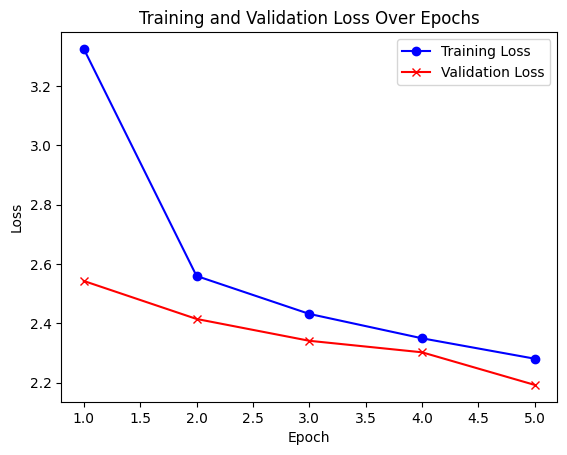

Params: {'audio_head': 16, 'audio_layers': 2, 'batch_size': 32, 'epochs': 5, 'learning_rate': 0.0001, 'text_head': 16, 'text_layers': 2, 'video_head': 16, 'video_layers': 2}
Intent Accuracy: 0.6196
Majority Intent Accuracy: 0.7838
Less Frequent Intent Accuracy: 0.0175
Emotion Accuracy: 0.5910
Majority Emotion Accuracy: 0.6079
Less Frequent Emotion Accuracy: 0.5749
Average Accuracy: 0.6053
f1-score Intent0.6196
f1-score Emotion0.590951
JRBM: 0.604924


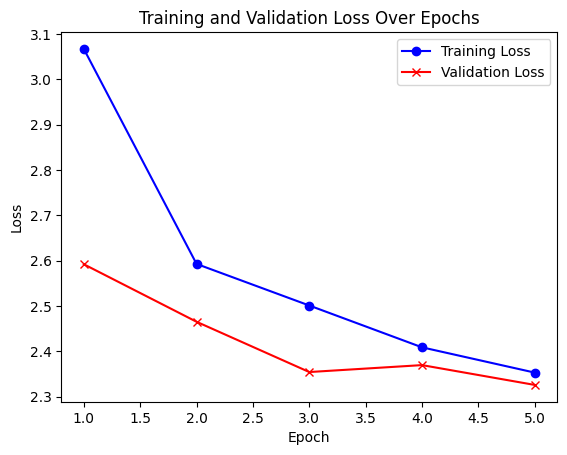

Params: {'audio_head': 16, 'audio_layers': 2, 'batch_size': 16, 'epochs': 5, 'learning_rate': 0.0001, 'text_head': 16, 'text_layers': 2, 'video_head': 16, 'video_layers': 2}
Intent Accuracy: 0.5993
Majority Intent Accuracy: 0.7450
Less Frequent Intent Accuracy: 0.0652
Emotion Accuracy: 0.5900
Majority Emotion Accuracy: 0.6145
Less Frequent Emotion Accuracy: 0.5714
Average Accuracy: 0.5946
f1-score Intent0.5993
f1-score Emotion0.590028
JRBM: 0.594608
Best Parameters: {'audio_head': 16, 'audio_layers': 2, 'batch_size': 32, 'epochs': 5, 'learning_rate': 0.0001, 'text_head': 16, 'text_layers': 2, 'video_head': 16, 'video_layers': 2}, Best JRBM: 0.6049


In [6]:
"""
 下面的代码是在验证集上面搜索最优的超参数
""" 

best_params = None
best_accuracy = 0  # Track highest accuracy instead of loss

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for params in ParameterGrid(param_grid):
    # 加载数据集
    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=False)

    
    # 初始化模型,也可以指定分别训练好的transformer来加载模型, 初始化时传递参数就好
    # 注意，使用预先训练好的transformer的nhead和layers要对应训练时候的
    model = MultimodalEmotionRecognition(
        text_dim=TEXT_DIM, audio_dim=AUDIO_DIM, video_dim=VIDEO_DIM, 
        intent_classes=8, emotion_classes=7, 
        text_head=params['text_head'], text_layers=params['text_layers'],  # 文本 Transformer 参数
        audio_head=params['audio_head'], audio_layers=params['audio_layers'],  # 音频 Transformer 参数
        video_head=params['video_head'], video_layers=params['video_layers'],  # 视频 Transformer 参数
    ).to(DEVICE)

    #kaiming 初始化
    model.apply(init_weights)

    # 定义优化器
    optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])
    criterion = nn.CrossEntropyLoss()

    # 统计每一轮的训练集loss和验证集loss，画图
    train_loss_values = []
    val_loss_values = []

# -------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------模型训练---------------------------------------------------------------
# -------------------------------------------------------------------------------------------------------------------

    # 训练模型
    for epoch in range(params['epochs']):
        model.train()
        total_loss = 0
        for text, audio,video,intent_label, emotion_label in train_loader:
            text,audio,video = text.to(DEVICE),audio.to(DEVICE),video.to(DEVICE)
            
            intent_label, emotion_label = intent_label.to(DEVICE), emotion_label.to(DEVICE)

            optimizer.zero_grad()
            intent_output, emotion_output = model(text,audio,video)
            
            loss_intent = criterion(intent_output, intent_label)
            loss_emotion = criterion(emotion_output, emotion_label)

            loss = loss_intent + loss_emotion #合并loss
            
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        train_loss_values.append(avg_loss)

        # 模型验证阶段
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for text,audio,video,intent_label,emotion_label in val_loader:
                text,audio,video = text.to(DEVICE),audio.to(DEVICE),video.to(DEVICE)
                intent_label, emotion_label = intent_label.to(DEVICE), emotion_label.to(DEVICE)
                intent_output, emotion_output = model(text,audio,video)
                loss_intent = criterion(intent_output, intent_label)
                loss_emotion = criterion(emotion_output, emotion_label)
                loss = loss_intent + loss_emotion
                total_val_loss += loss.item()
        avg_val_loss = total_val_loss / len(val_loader)
        val_loss_values.append(avg_val_loss)  # 保存验证集loss    

    plt.plot(range(1, params['epochs'] + 1), train_loss_values, marker='o', label='Training Loss', color='blue')
    plt.plot(range(1, params['epochs'] + 1), val_loss_values, marker='x', label='Validation Loss', color='red')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Over Epochs")
    plt.legend()
    plt.show()

# -------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------模型评测---------------------------------------------------------------
# -------------------------------------------------------------------------------------------------------------------

    model.eval()

    # 用于计算正确率的辅助变量
    intent_accuracy_metric = Accuracy(task="multiclass",num_classes=8).to(DEVICE)
    emotion_accuracy_metric = Accuracy(task="multiclass",num_classes=7).to(DEVICE)
    majority_intent_accuracy_metric = Accuracy(task="multiclass",num_classes=8).to(DEVICE)
    majority_emotion_accuracy_metric = Accuracy(task="multiclass",num_classes=7).to(DEVICE)
    less_intent_accuracy_metric = Accuracy(task="multiclass",num_classes=8).to(DEVICE)
    less_emotion_accuracy_metric = Accuracy(task="multiclass",num_classes=7).to(DEVICE)
    total = 0

    # 用于计算JRPM指标的辅助变量
    all_intent_preds = []
    all_intent_labels = []
    all_emotion_preds = []
    all_emotion_labels = []

    # 这个循环会对 params 所生成的模型进行保存
    with torch.no_grad():
        for text, audio,video,intent_label,emotion_label in val_loader:
            text,audio,video = text.to(DEVICE),audio.to(DEVICE),video.to(DEVICE)
            intent_label, emotion_label = intent_label.to(DEVICE), emotion_label.to(DEVICE)
            
            intent_output, emotion_output = model(text,audio,video)

            _, predicted_intent = torch.max(intent_output, 1)
            _, predicted_emotion = torch.max(emotion_output, 1)

            all_intent_preds.extend(predicted_intent.cpu().numpy())
            all_intent_labels.extend(intent_label.cpu().numpy())
            all_emotion_preds.extend(predicted_emotion.cpu().numpy())
            all_emotion_labels.extend(emotion_label.cpu().numpy())
            
            # 筛选出 emotion 和 intent 多数标签的 mask
            mask1 = torch.isin(intent_label, torch.tensor([4, 0, 3], device=DEVICE))
            mask2 = torch.isin(intent_label, torch.tensor([4, 5], device=DEVICE))

            # 更新总体准确率
            intent_accuracy_metric.update(predicted_intent, intent_label)
            emotion_accuracy_metric.update(predicted_emotion, emotion_label)
            
            # 更新多数类别的准确率
            if mask2.sum() > 0:
                majority_intent_accuracy_metric.update(predicted_intent[mask2], intent_label[mask2])
            if mask1.sum() > 0:
                majority_emotion_accuracy_metric.update(predicted_emotion[mask1], emotion_label[mask1])
            
            # 更新少数类别的准确率
            if (total - mask2.sum().item()) > 0 and (predicted_intent[~mask2].shape[0] > 0):
                less_intent_accuracy_metric.update(predicted_intent[~mask2], intent_label[~mask2])
            if (total - mask1.sum().item()) > 0 and (predicted_emotion[~mask1].shape[0] > 0):
                less_emotion_accuracy_metric.update(predicted_emotion[~mask1], emotion_label[~mask1])
                
            total += intent_label.size(0)

    #计算准确率
    intent_accuracy = intent_accuracy_metric.compute()
    emotion_accuracy = emotion_accuracy_metric.compute()
    majority_intent_accuracy = majority_intent_accuracy_metric.compute()
    majority_emotion_accuracy = majority_emotion_accuracy_metric.compute()
    less_intent_accuracy = less_intent_accuracy_metric.compute()
    less_emotion_accuracy = less_emotion_accuracy_metric.compute()
    avg_accuracy = (intent_accuracy + emotion_accuracy) / 2

    #计算JRPM(比赛用的指标)
    intent_f1 = f1_score(all_intent_labels, all_intent_preds, average='micro')
    emotion_f1 = f1_score(all_emotion_labels, all_emotion_preds, average='micro')
    joint_metrics = harmonic_mean(emotion_f1, intent_f1)

    # 保存最佳模型参数
    if joint_metrics > best_accuracy:
        best_accuracy = joint_metrics
        best_params = params

    print(f"Params: {params}")
    print(f"Intent Accuracy: {intent_accuracy.item():.4f}")
    print(f"Majority Intent Accuracy: {majority_intent_accuracy.item():.4f}")
    print(f"Less Frequent Intent Accuracy: {less_intent_accuracy.item():.4f}")
    print(f"Emotion Accuracy: {emotion_accuracy.item():.4f}")
    print(f"Majority Emotion Accuracy: {majority_emotion_accuracy.item():.4f}")
    print(f"Less Frequent Emotion Accuracy: {less_emotion_accuracy.item():.4f}")
    print(f"Average Accuracy: {avg_accuracy.item():.4f}")
    print(f"f1-score Intent{intent_f1:.4f}")
    print(f"f1-score Emotion{emotion_f1:4f}")
    print(f"JRBM: {joint_metrics:4f}")
    
print(f"Best Parameters: {best_params}, Best JRBM: {best_accuracy:.4f}")

In [7]:
"""
1. 保存之前搜寻到的最优超参数对应的模型, 模型保存路径在 config.py 定义
2. 在测试集上测试，生成测试结果
"""

# 需要修改，指定模型的名字
model_name = "10_31_xmodel"

# 模型会保存在这个地址，其中EST_MODEL_SAVE_DIR是在config.py中定义的
model_save_path = f"{cf.BEST_MODEL_SAVE_DIR}{model_name}"
# 也可以直接指定比如 model_save_path =  "/home/ubuntu/zlb/MEIJU/model/save/10_31_model"

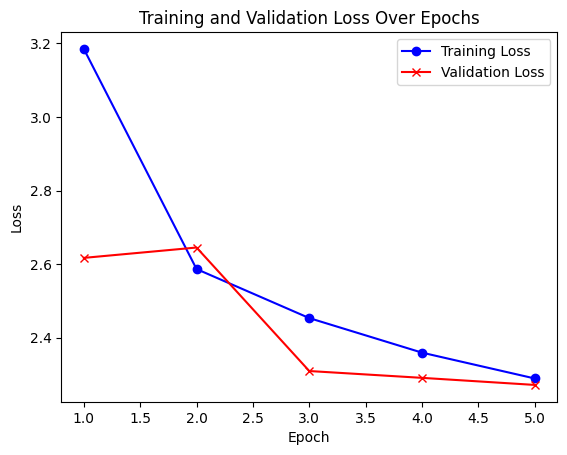

Params: {'audio_head': 16, 'audio_layers': 2, 'batch_size': 32, 'epochs': 5, 'learning_rate': 0.0001, 'text_head': 16, 'text_layers': 2, 'video_head': 16, 'video_layers': 2}
Intent Accuracy: 0.6159
Majority Intent Accuracy: 0.7720
Less Frequent Intent Accuracy: 0.0439
Emotion Accuracy: 0.5817
Majority Emotion Accuracy: 0.6123
Less Frequent Emotion Accuracy: 0.5570
Average Accuracy: 0.5988
f1-score Intent0.6159
f1-score Emotion0.581717
JRBM: 0.598312
模型下载到：/home/ubuntu/zlb/MEIJU/model/save/10_31_xmodel.pth
被保存模型的参数为：{'audio_head': 16, 'audio_layers': 2, 'batch_size': 32, 'epochs': 5, 'learning_rate': 0.0001, 'text_head': 16, 'text_layers': 2, 'video_head': 16, 'video_layers': 2}


In [8]:
# 不用展开这一块，很多之前的代码，指定好了保存的地方直接运行

# -------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------下面不用修改--------------------------------------------------------------
# -------------------------------------------------------------------------------------------------------------------


# --------------------------------------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------下面是重新训练最好参数的模型并且保存，代码会很长,不用看--------------------------------------------------------------
# --------------------------------------------------------------------------------------------------------------------------------------------------

params = best_params

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 加载数据集
train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=False)

# 初始化模型
model = MultimodalEmotionRecognition(
    text_dim=TEXT_DIM, audio_dim=AUDIO_DIM, video_dim=VIDEO_DIM, 
    intent_classes=8, emotion_classes=7, 
    text_head=params['text_head'], text_layers=params['text_layers'],  # 文本 Transformer 参数
    audio_head=params['audio_head'], audio_layers=params['audio_layers'],  # 音频 Transformer 参数
    video_head=params['video_head'], video_layers=params['video_layers'],  # 视频 Transformer 参数
).to(DEVICE)

#kaiming 初始化
model.apply(init_weights)

# 定义优化器
optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])
criterion = nn.CrossEntropyLoss()

# 统计每一轮的训练集loss和验证集loss，画图
train_loss_values = []
val_loss_values = []

# 训练模型
for epoch in range(params['epochs']):
    model.train()
    total_loss = 0
    for text, audio,video,intent_label, emotion_label in train_loader:
        text,audio,video = text.to(DEVICE),audio.to(DEVICE),video.to(DEVICE)
        
        intent_label, emotion_label = intent_label.to(DEVICE), emotion_label.to(DEVICE)

        optimizer.zero_grad()
        intent_output, emotion_output = model(text,audio,video)
        
        loss_intent = criterion(intent_output, intent_label)
        loss_emotion = criterion(emotion_output, emotion_label)

        loss = loss_intent + loss_emotion #合并loss
        
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    train_loss_values.append(avg_loss)

    # 模型验证阶段
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for text,audio,video,intent_label,emotion_label in val_loader:
            text,audio,video = text.to(DEVICE),audio.to(DEVICE),video.to(DEVICE)
            intent_label, emotion_label = intent_label.to(DEVICE), emotion_label.to(DEVICE)
            intent_output, emotion_output = model(text,audio,video)
            loss_intent = criterion(intent_output, intent_label)
            loss_emotion = criterion(emotion_output, emotion_label)
            loss = loss_intent + loss_emotion
            total_val_loss += loss.item()
    avg_val_loss = total_val_loss / len(val_loader)
    val_loss_values.append(avg_val_loss)  # 保存验证集loss    

plt.plot(range(1, params['epochs'] + 1), train_loss_values, marker='o', label='Training Loss', color='blue')
plt.plot(range(1, params['epochs'] + 1), val_loss_values, marker='x', label='Validation Loss', color='red')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.show()

model.eval()

# 用于计算正确率的辅助变量
intent_accuracy_metric = Accuracy(task="multiclass",num_classes=8).to(DEVICE)
emotion_accuracy_metric = Accuracy(task="multiclass",num_classes=7).to(DEVICE)
majority_intent_accuracy_metric = Accuracy(task="multiclass",num_classes=8).to(DEVICE)
majority_emotion_accuracy_metric = Accuracy(task="multiclass",num_classes=7).to(DEVICE)
less_intent_accuracy_metric = Accuracy(task="multiclass",num_classes=8).to(DEVICE)
less_emotion_accuracy_metric = Accuracy(task="multiclass",num_classes=7).to(DEVICE)
total = 0

# 用于计算JRPM指标的辅助变量
all_intent_preds = []
all_intent_labels = []
all_emotion_preds = []
all_emotion_labels = []

# 这个循环会对 params 所生成的模型进行保存
with torch.no_grad():
    for text, audio,video,intent_label,emotion_label in val_loader:
        text,audio,video = text.to(DEVICE),audio.to(DEVICE),video.to(DEVICE)
        intent_label, emotion_label = intent_label.to(DEVICE), emotion_label.to(DEVICE)
        
        intent_output, emotion_output = model(text,audio,video)

        _, predicted_intent = torch.max(intent_output, 1)
        _, predicted_emotion = torch.max(emotion_output, 1)

        all_intent_preds.extend(predicted_intent.cpu().numpy())
        all_intent_labels.extend(intent_label.cpu().numpy())
        all_emotion_preds.extend(predicted_emotion.cpu().numpy())
        all_emotion_labels.extend(emotion_label.cpu().numpy())
        
        # 筛选出 emotion 和 intent 多数标签的 mask
        mask1 = torch.isin(intent_label, torch.tensor([4, 0, 3], device=DEVICE))
        mask2 = torch.isin(intent_label, torch.tensor([4, 5], device=DEVICE))

        # 更新总体准确率
        intent_accuracy_metric.update(predicted_intent, intent_label)
        emotion_accuracy_metric.update(predicted_emotion, emotion_label)
        
        # 更新多数类别的准确率
        if mask2.sum() > 0:
            majority_intent_accuracy_metric.update(predicted_intent[mask2], intent_label[mask2])
        if mask1.sum() > 0:
            majority_emotion_accuracy_metric.update(predicted_emotion[mask1], emotion_label[mask1])
        
        # 更新少数类别的准确率
        if (total - mask2.sum().item()) > 0 and (predicted_intent[~mask2].shape[0] > 0):
            less_intent_accuracy_metric.update(predicted_intent[~mask2], intent_label[~mask2])
        if (total - mask1.sum().item()) > 0 and (predicted_emotion[~mask1].shape[0] > 0):
            less_emotion_accuracy_metric.update(predicted_emotion[~mask1], emotion_label[~mask1])
            
        total += intent_label.size(0)

#计算准确率
intent_accuracy = intent_accuracy_metric.compute()
emotion_accuracy = emotion_accuracy_metric.compute()
majority_intent_accuracy = majority_intent_accuracy_metric.compute()
majority_emotion_accuracy = majority_emotion_accuracy_metric.compute()
less_intent_accuracy = less_intent_accuracy_metric.compute()
less_emotion_accuracy = less_emotion_accuracy_metric.compute()
avg_accuracy = (intent_accuracy + emotion_accuracy) / 2

#计算JRPM(比赛用的指标)
intent_f1 = f1_score(all_intent_labels, all_intent_preds, average='micro')
emotion_f1 = f1_score(all_emotion_labels, all_emotion_preds, average='micro')
joint_metrics = harmonic_mean(emotion_f1, intent_f1)

# 保存最佳模型参数
if joint_metrics > best_accuracy:
    best_accuracy = joint_metrics
    best_params = params

print(f"Params: {params}")
print(f"Intent Accuracy: {intent_accuracy.item():.4f}")
print(f"Majority Intent Accuracy: {majority_intent_accuracy.item():.4f}")
print(f"Less Frequent Intent Accuracy: {less_intent_accuracy.item():.4f}")
print(f"Emotion Accuracy: {emotion_accuracy.item():.4f}")
print(f"Majority Emotion Accuracy: {majority_emotion_accuracy.item():.4f}")
print(f"Less Frequent Emotion Accuracy: {less_emotion_accuracy.item():.4f}")
print(f"Average Accuracy: {avg_accuracy.item():.4f}")
print(f"f1-score Intent{intent_f1:.4f}")
print(f"f1-score Emotion{emotion_f1:4f}")
print(f"JRBM: {joint_metrics:4f}")


print(f'模型下载到：{model_save_path}.pth')
torch.save(model.state_dict(), f'{model_save_path}.pth')
print(f"被保存模型的参数为：{params}")
